In [47]:



import gc
import os

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.colors import to_rgb
from sklearn.preprocessing import MinMaxScaler

DATA_PATH = '../../data/'

gc.collect()


7892

In [48]:


# get opponent team id
def get_opponent_team_id(data):
    
    opps = data.copy()[['game_id','team_id']].drop_duplicates().reset_index(drop=True)
    opps['team_AorB'] = opps.groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    opps = opps.pivot(index='game_id', columns=['team_AorB'], values='team_id').reset_index()
    opps.columns=['game_id','team_id','opp_id']
    opps2 = opps.copy()
    opps2.columns=['game_id','opp_id','team_id']
    opps = pd.concat([opps, opps2], axis=0).dropna().reset_index(drop=True)
    opps['team_id'] = opps['team_id'].astype(int)
    opps['opp_id'] = opps['opp_id'].astype(int)
    
    return opps



In [49]:



def get_possessions(pbox_data):
    
    opponent_ids = get_opponent_team_id(pbox_data.copy())
    ## estimate number of possessions from box score 
    poss = pbox_data.groupby(['game_id','team_id'])[['fga','to','fta','oreb']].sum().reset_index()
    ## commonly used possession estimate formula
    ## (FGA – OR) + TO + (0.44 * FTA)
    poss['tm_poss'] = (poss['fga'].copy()-poss['oreb'].copy())+poss['to'].copy()+(0.44*poss['fta'].copy())
    poss = poss.drop(columns=['fga','to','fta','oreb'])

    possession_key = opponent_ids.copy().merge(poss, how='left', on=['game_id','team_id'])
    poss = poss.rename(columns={'team_id':'opp_id','tm_poss':'opp_poss'})
    possession_key = possession_key.copy().merge(poss, how='left', on=['game_id','opp_id'])
    possession_key['game_possessions'] = possession_key[['tm_poss','opp_poss']].copy().mean(axis=1)
    possession_key = possession_key.drop(columns=['tm_poss','opp_poss','opp_id'])

    return possession_key.sort_values(by='game_id').reset_index(drop=True)

def add_player_boxscore_features(data):
    
    #pbox
    data['fgm'] = data['fg'].apply(lambda x: x.split('-')[0])
    data['fga'] = data['fg'].apply(lambda x: x.split('-')[-1])
    data['fg3m'] = data['fg3'].apply(lambda x: x.split('-')[0])
    data['fg3a'] = data['fg3'].apply(lambda x: x.split('-')[-1])
    data['ftm'] = data['ft'].apply(lambda x: x.split('-')[0])
    data['fta'] = data['ft'].apply(lambda x: x.split('-')[-1])

    data['fgm']= data['fgm'].replace('',0)
    data['fgm'] = data['fgm'].astype(int)
    data['fga']= data['fga'].replace('',0)
    data['fga'] = data['fga'].astype(int)
    data['ftm']= data['ftm'].replace('',0)
    data['ftm'] = data['ftm'].astype(int)
    data['fta']= data['fta'].replace('',0)
    data['fta'] = data['fta'].astype(int)
    
    data['oreb']= data['oreb'].replace('',0)
    data['oreb'] = data['oreb'].astype(int)
    data['dreb']= data['dreb'].replace('',0)
    data['dreb'] = data['dreb'].astype(int)
    data['reb']= data['reb'].replace('',0)
    data['reb'] = data['reb'].astype(int)

    data['fg3m']= data['fg3m'].replace('',0)
    data['fg3m'] = data['fg3m'].astype(int)
    data['fg3a']= data['fg3a'].replace('',0)
    data['fg3a'] = data['fg3a'].astype(int)

    data['fg2m'] = data['fgm'].copy()-data['fg3m'].copy()
    data['fg2a'] = data['fga'].copy()-data['fg3a'].copy()
    
    possess = get_possessions(data.copy())
    data = data.merge(possess, how='left', on=['game_id','team_id'])

    data['fg%'] = (data['fgm'].copy()/data['fga'].copy()).fillna(0)
    data['fg2%'] = (data['fg2m'].copy()/data['fg2a'].copy()).fillna(0)
    data['fg3%'] = (data['fg3m'].copy()/data['fg3a'].copy()).fillna(0)

    data['eFG%'] = ((data['fgm'].copy()+(data['fg3m'].copy()*0.5))/data['fga'].copy()).fillna(0)
    data['TS%'] = ((data['pts'].copy())/(2*(data['fga'].copy()+(0.44*data['fta'].copy())))).fillna(0)
    # pbox[['fg','fg3m','fga']].dtypes
    data['pts_pm'] = data['pts'].copy()/data['min'].copy()
    data['reb_pm'] = data['reb'].copy()/data['min'].copy()
    data['ast_pm'] = data['ast'].copy()/data['min'].copy()
    data['stl_pm'] = data['stl'].copy()/data['min'].copy()
    data['blk_pm'] = data['blk'].copy()/data['min'].copy()
    data['to_pm'] = data['to'].copy()/data['min'].copy()
    data['pf_pm'] = data['pf'].copy()/data['min'].copy()
    
    ## could be improved with OT markers
    ## percentage of estimated possessions player took part of
    data['player_possessions'] = data['game_possessions'].copy()*(data['min'].copy()/(40*2)) # times 2 because game possessions = 
    
    data['pts_pp'] = data['pts'].copy()/data['player_possessions'].copy()
    data['reb_pp'] = data['reb'].copy()/data['player_possessions'].copy()
    data['ast_pp'] = data['ast'].copy()/data['player_possessions'].copy()
    data['stl_pp'] = data['stl'].copy()/data['player_possessions'].copy()
    data['blk_pp'] = data['blk'].copy()/data['player_possessions'].copy()
    data['to_pp'] = data['to'].copy()/data['player_possessions'].copy()
    data['pf_pp'] = data['pf'].copy()/data['player_possessions'].copy()
    
    return data


def clean_player_boxscores(data):
    for stat_col in ['min','pts','oreb','dreb','reb','ast','stl','blk','to','pf']:
        data[stat_col] = data[stat_col].replace('--',0)
        data[stat_col] = data[stat_col].astype(int)

    return data


def load_player_boxscore_season(year):
    return add_player_boxscore_features(\
            clean_player_boxscores(\
            pd.read_csv(os.path.join(DATA_PATH, f'ESPN/player_boxscores/{year}.csv'))))



In [50]:


def create_graph(graph_data):
    
    
    p2p1 = graph_data.copy().loc[graph_data['p2p1']==1].reset_index(drop=True)
    p1p2 = graph_data.copy().loc[graph_data['p2p1']==0].reset_index(drop=True)

    nodes = list(set(list(graph_data.player_1_id.unique())+list(graph_data.player_2_id.unique())))
#     print(f"There are {len(nodes)} players")

    p2p1 = p2p1[['player_2_id','player_1_id','edge_weight']]
    p1p2 = p1p2[['player_1_id','player_2_id','edge_weight']]
    p2p1.columns=['sender','receiver','edge_weight']
    p1p2.columns=['sender','receiver','edge_weight']

    edges = pd.concat([p2p1, p1p2], axis=0).reset_index(drop=True)
    edges = [tuple([e[0], e[1], e[2]]) for e in edges.values]
    
#     print(f"There are {np.round(len(edges)/len(nodes))} observations per player, on average")
    
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    
    return G


def get_pagerank(net, stat, min_threshold=5):
    
    net = net.copy().loc[net['min']>=min_threshold].reset_index(drop=True)
    
    net = net[['game_id','team_id','athlete_id',stat,'min']]
    net['team_order'] = net.copy().groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
        1:'A',
        2:'B'
    })
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('dense').astype(int)
    # re rank after cutoff
    net = net.sort_values(by=['game_id','team_id','min'], ascending=[True, True, False])
    net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('first',ascending=False).astype(int)
    net = net.loc[net['player_order']<=8].reset_index(drop=True)
    net['player_team_id'] = net['team_order'].astype(str) + '-' +net['player_order'].astype(str)
    
    net = net.pivot(index='game_id', columns='player_team_id', values=['athlete_id',stat]).reset_index()
    
    net_data = []
    for player_1 in [f'A-{i}' for i in range(1, 9)]:
        for player_2 in [f'B-{i}' for i in range(1, 9)]:
            matchup = pd.concat([net['athlete_id'][[player_1, player_2]], net[stat][[player_1, player_2]]], axis=1)
            matchup.columns=['player_1_id','player_2_id','player_1_pts','player_2_pts']
            net_data.append(matchup)

    net_data = pd.concat(net_data)
    
    net_data = net_data.dropna().reset_index(drop=True)
    net_data['player_1_id'] = net_data['player_1_id'].astype(int)
    net_data['player_2_id'] = net_data['player_2_id'].astype(int)

    # if ppm equal, no blood (no link)
    net_data['to_drop'] = np.where(net_data['player_1_pts']==net_data['player_2_pts'], 1, 0)
    net_data = net_data.loc[net_data['to_drop']==0].reset_index(drop=True)
    net_data = net_data.drop(columns=['to_drop'])
    net_data['p2p1'] = np.where(net_data['player_1_pts']>net_data['player_2_pts'],1,0)
    net_data['edge_weight'] = (net_data['player_1_pts'] - net_data['player_2_pts']).abs() 
    
    graph = create_graph(net_data.copy())
    
    prnk = nx.pagerank(graph)
    prnk = pd.Series(prnk).reset_index()
    
    prnk.columns=['player_id', f'{stat}_prnk']
    
    # standardize by degree
    degrees = pd.DataFrame.from_dict(graph.degree())
    degrees.columns=['player_id','degree']
    prnk = prnk.copy().merge(degrees, how='left', on='player_id')
    prnk[f'{stat}_norm_prnk'] = 100000* (prnk[f'{stat}_prnk'].copy()/prnk['degree'].copy())
    prnk = prnk.sort_values(by=f'{stat}_norm_prnk', ascending=False)
    
    prnk = prnk.loc[prnk['degree']>20]  # minimum 100 opponent players played (~12-15 games)
    
    return prnk.sort_values(by=[f'{stat}_norm_prnk'], ascending=False).drop(columns=['degree']).reset_index(drop=True)

year = 2022
pbox = load_player_boxscore_season(year)
pbox['team_name'] = pbox['team_short_display_name'].copy() + ' ' + pbox['team_name'].copy()
opponent_ids = get_opponent_team_id(pbox.copy())
## create name mapping
players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
players_name2id = {v:k for k,v in players_id2name.items()}

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_short_display_name']].set_index('athlete_id').to_dict()['team_short_display_name']

teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}



/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_65801/2515957558.py:84: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(year)


In [65]:


net = pbox.copy()
min_threshold = 8
stat = 'reb_pm'
net = net.loc[net['min']>=min_threshold].reset_index(drop=True)

net = net[['game_id','team_id','athlete_id',stat,'min']]
net['team_order'] = net.copy().groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
    1:'A',
    2:'B'
})
net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('dense').astype(int)
# re rank after cutoff
net = net.sort_values(by=['game_id','team_id','min'], ascending=[True, True, False])
net['player_order'] = net.copy().groupby(['game_id','team_id'])['min'].rank('first',ascending=False).astype(int)
net = net.loc[net['player_order']<=8].reset_index(drop=True)
net['player_team_id'] = net['team_order'].astype(str) + '-' +net['player_order'].astype(str)

net = net.pivot(index='game_id', columns='player_team_id', values=['athlete_id',stat]).reset_index()

net_data = []
for player_1 in [f'A-{i}' for i in range(1, 9)]:
    for player_2 in [f'B-{i}' for i in range(1, 9)]:
        matchup = pd.concat([net['athlete_id'][[player_1, player_2]], net[stat][[player_1, player_2]]], axis=1)
        matchup.columns=['player_1_id','player_2_id','player_1_pts','player_2_pts']
        net_data.append(matchup)

net_data = pd.concat(net_data)

net_data = net_data.dropna().reset_index(drop=True)
net_data['player_1_id'] = net_data['player_1_id'].astype(int)
net_data['player_2_id'] = net_data['player_2_id'].astype(int)

# if ppm equal, no blood (no link)
net_data['to_drop'] = np.where(net_data['player_1_pts']==net_data['player_2_pts'], 1, 0)
net_data = net_data.loc[net_data['to_drop']==0].reset_index(drop=True)
net_data = net_data.drop(columns=['to_drop'])
net_data['p2p1'] = np.where(net_data['player_1_pts']>net_data['player_2_pts'],1,0)
net_data['edge_weight'] = (net_data['player_1_pts'] - net_data['player_2_pts']).abs() 

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_name']].set_index('athlete_id').to_dict()['team_name']
teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_name']].set_index('team_id').to_dict()['team_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}
net_data['team_1_name'] = net_data['player_1_id'].map(players_id2team)
net_data['team_2_name'] = net_data['player_2_id'].map(players_id2team)

net_data['team_1_id'] = net_data['team_1_name'].map(teams_name2id)
net_data['team_2_id'] = net_data['team_2_name'].map(teams_name2id)
net_data = net_data.dropna(subset=['team_1_id','team_2_id']).reset_index(drop=True)
net_data['team_1_id'] = net_data['team_1_id'].astype(int)
net_data['team_2_id'] = net_data['team_2_id'].astype(int)





In [66]:

def rgb_to_hsl(r, g, b):
    r = float(r)
    g = float(g)
    b = float(b)
    high = max(r, g, b)
    low = min(r, g, b)
    h, s, v = ((high + low) / 2,)*3

    if high == low:
        h = 0.0
        s = 0.0
    else:
        d = high - low
        s = d / (2 - high - low) if l > 0.5 else d / (high + low)
        h = {
            r: (g - b) / d + (6 if g < b else 0),
            g: (b - r) / d + 2,
            b: (r - g) / d + 4,
        }[high]
        h /= 6

    return h, s, v

def complementaryColor(my_hex):
    if my_hex[0] == '#':
        my_hex = my_hex[1:]
    rgb = (my_hex[0:2], my_hex[2:4], my_hex[4:6])
    comp = ['%02X' % (255 - int(a, 16)) for a in rgb]
    return ''.join(comp)

def determine_darker_color(c1, c2):
    r, g, b = c1
    r2, g2, b2 = c2
    hsp1 = 0.299 * (r * r) + 0.587 * (g * g) + 0.114 * (b * b)
    hsp2 = 0.299 * (r2 * r2) + 0.587 * (g2 * g2) + 0.114 * (b2 * b2)
    
    if hsp1 > hsp2:
        # darker is hsp2
        return 0
    elif hsp1 < hsp2:
        return 1
    else:
        print(hsp1, hsp2)
        raise ValueError() # same color


In [67]:

team_meta = pd.read_csv('team_meta.csv')
teams_id2conf = team_meta.copy().drop_duplicates(subset=['ESPN_team_id'])[['ESPN_team_id','conference_name']].set_index('ESPN_team_id').to_dict()['conference_name']

# fill nas with complementary
# don't want these being the same
team_meta['secondary_color'] = np.where(team_meta['primary_color']==team_meta['secondary_color'], np.nan, team_meta['secondary_color'].copy())
# one special case
team_meta.loc[team_meta['ESPN_team_id']==57, 'secondary_color'] = 'FA4616'
team_meta['rgb_primary'] = team_meta['primary_color'].apply(lambda x: to_rgb('#'+x))
team_meta['secondary_color'] = team_meta['secondary_color'].fillna(team_meta['primary_color'].apply(lambda x: complementaryColor(x)))
team_meta['rgb_secondary'] = team_meta['secondary_color'].apply(lambda x: to_rgb('#'+str(x)))
team_meta['primary_darker'] = team_meta.apply(lambda x: determine_darker_color(x.rgb_primary, x.rgb_secondary), axis=1)

team_meta['darker_color'] = np.where(team_meta['primary_darker']==1, team_meta['primary_color'].copy(), team_meta['secondary_color'].copy())
team_meta['lighter_color'] = np.where(team_meta['primary_darker']==0, team_meta['primary_color'].copy(), team_meta['secondary_color'].copy())
team_meta['darker_color'] = '#' + team_meta['darker_color'].copy()
team_meta['lighter_color'] = '#' + team_meta['lighter_color'].copy()


In [108]:
print(list(net_data))

['player_1_id', 'player_2_id', 'player_1_pts', 'player_2_pts', 'p2p1', 'edge_weight', 'team_1_name', 'team_2_name', 'team_1_id', 'team_2_id']


In [69]:


team_dark = team_meta.copy()[['ESPN_team_id','darker_color']].set_index('ESPN_team_id').to_dict()['darker_color']
team_light = team_meta.copy()[['ESPN_team_id','lighter_color']].set_index('ESPN_team_id').to_dict()['lighter_color']


In [155]:
conf_teams = team_meta.groupby(['conference_name'])['ESPN_team_id'].apply(set).to_dict()
team_players = net_data.groupby('team_1_id')['player_1_id'].apply(set).to_dict()
team_players_2 = net_data.groupby('team_2_id')['player_2_id'].apply(set).to_dict()

for team2, players2 in team_players_2.items():
    if team2 not in team_players:
        team_players[team2] = players2
    else:
        team_players[team2] = team_players[team2].union(players2)


In [197]:

import pickle
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di
# save_dict(conf_teams, '../../src/network_viz_data/conf_teams')
# save_dict(team_players, '../../src/network_viz_data/team_players')

# save_dict(players_id2name, '../../src/network_viz_data/players_id2name')

In [160]:

# conf_teams
# team_players[2390]


In [161]:

# season = 2022
# net_data['season'] = season
# net_data['conference_1'] = net_data['team_1_id'].map(teams_id2conf)
# net_data['conference_2'] = net_data['team_2_id'].map(teams_id2conf)

# conf = 'Big 12'
# conf_data = net_data.copy().loc[(net_data['conference_1']==conf) & (net_data['conference_2']==conf)].reset_index(drop=True)



In [184]:

g = create_graph(net_data.copy())
prnk = nx.pagerank(g, alpha=1)

nx.write_gml(g, "../../src/network_viz_data/reb_graph.gml", stringizer=str)
g = nx.read_gml('../../src/network_viz_data/reb_graph.gml')


In [318]:

def draw_player_reb(graph, conf):
    
    teams = conf_teams[conf]
    teams = [t for t in teams if t in teams_id2name.keys()]
#     teams = list(teams_id2name.keys())
#     teams = [t for t in teams if t in team_players.keys()]
    players = []
    for team in teams:
        players.extend(team_players[team])

    num_to_plot = 10
    player_pagerank = [(pid, prnk[pid]) for pid in players]
    player_pagerank = sorted(player_pagerank, key=lambda x: x[1], reverse=True)
    top_n = [p[0] for p in player_pagerank[:num_to_plot]]
    
    sub_g = g.subgraph([str(p) for p in top_n])

    # total labelled
    sub_nodes = sub_g.nodes()
    edges = sub_g.edges()
    pos = nx.spring_layout(sub_g)
    weights = [g[u][v]['weight'] * 3 for u,v in edges]
#     edge_colors = [team_dark[teams_name2id[players_id2team[int(e[1])]]] for e in sub_g.edges()] # color edges by receiver
    colors = [team_dark[teams_name2id[players_id2team[int(n)]]] for n in sub_nodes]
    labeldict = {p:players_id2name[int(p)] for p in sub_nodes}

    fig, ax = plt.subplots(figsize=(20,14))
    nx.draw(sub_g, width=weights, pos=pos, node_color=colors, edge_color=weights, edge_cmap=plt.cm.hot_r, node_size=[8e6*prnk[int(n)] for n in sub_nodes],
            cmap='winter',arrowsize=15, arrowstyle='Fancy')
    for j in sub_nodes:
        nx.draw_networkx_labels(sub_g.subgraph([j]), pos={j:pos[j]} , labels={j:labeldict[j]}, font_color='whitesmoke', font_size=12,
                               )
        
    plt.show()
    return



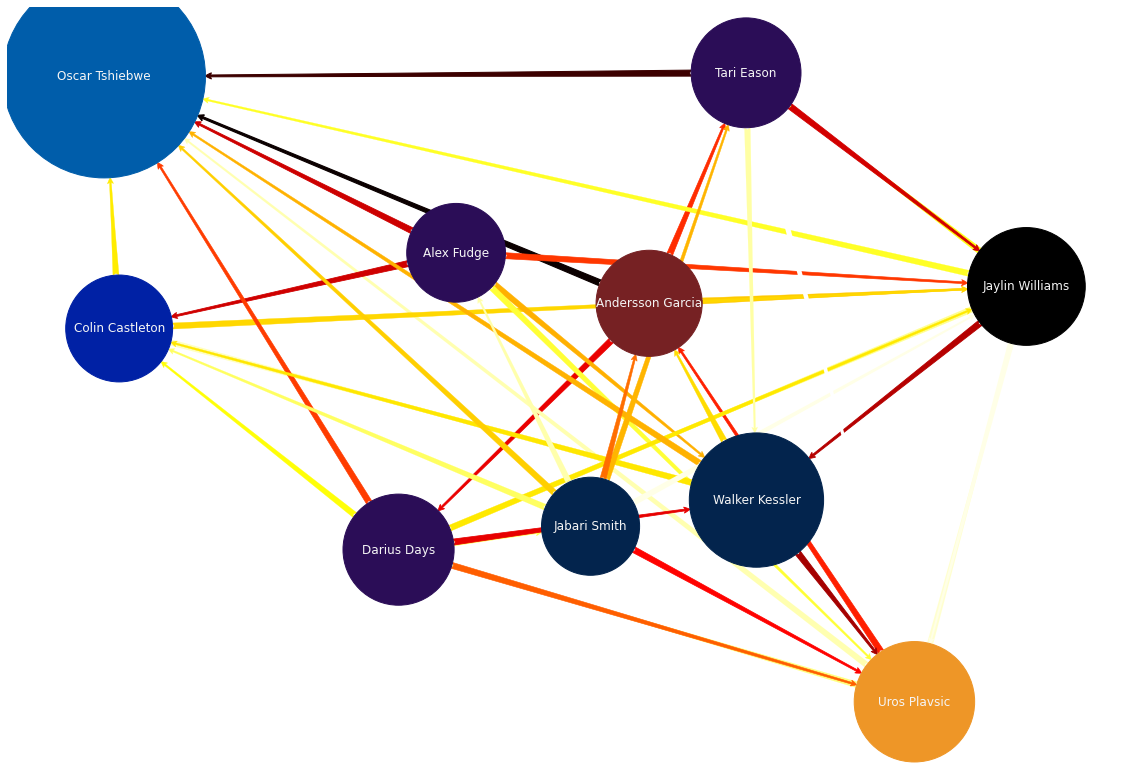

In [319]:

draw_player_reb(g, 'SEC')



In [129]:




stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)
tmp_prnk = tmp_prnk.sort_values(by='pts_pm_prnk',ascending=False)
tmp_prnk['player_name'] = tmp_prnk['player_id'].map(players_id2name)
tmp_prnk['player_team'] = tmp_prnk['player_id'].map(players_id2team)
tmp_prnk.head(20)



,player_id,pts_pm_prnk,pts_pm_norm_prnk,player_name,player_team
3,4594327,0.001633,0.732304,Keegan Murray,Iowa
1,4433192,0.001585,0.784575,Tari Eason,LSU
2,4600663,0.001548,0.774173,Zach Edey,Purdue
5,4432828,0.001324,0.685840,Kofi Cockburn,Illinois
14,4432639,0.001294,0.528088,Jabari Smith,Auburn
13,4431785,0.001226,0.537523,Scotty Pippen Jr.,Vanderbilt
21,4432821,0.001136,0.516320,E.J. Liddell,Ohio State
39,4592829,0.001129,0.455304,Quenton Jackson,Texas A&M
28,4397246,0.001106,0.482938,Trevion Williams,Purdue
32,4278412,0.001089,0.475614,Izaiah Brockington,Iowa State


In [ ]:
## for all stats/seasons
# player_ranks = pd.read_csv('./output/player_components.csv')

In [109]:

## already calculated
# player_ranks = []
# stats = ['eFG%','TS%','pts_pm','reb_pm','ast_pm','stl_pm','blk_pm','to_pm','pf_pm']
# for season in [2007,2008,2009,2010,2011,2012,2013,2014,2015, 2016,2017, 2018, 2019, 2020, 2021, 2022]:
#     season_player_rank = None
#     for stat_ in tqdm(stats):

#         pbox = load_player_boxscore_season(season)

#         # get ids
#         teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
#         teams_name2id = {v:k for k,v in teams_id2name.items()}
#         players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
#         players_name2id = {v:k for k,v in teams_id2name.items()}
        
#         players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'], keep='last')[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
        
#         tmp_prnk = get_pagerank(pbox, stat_)
#         if season_player_rank is None:
#             season_player_rank = tmp_prnk.copy()
#         else:
#             season_player_rank = season_player_rank.merge(tmp_prnk, how='left', on='player_id')

#     season_player_rank['season']=season
#     season_player_rank['player_name'] = season_player_rank['player_id'].map(players_id2name) + f'_{season}'
#     season_player_rank['player_team'] = season_player_rank['player_id'].map(players_id2team)
#     player_ranks.append(season_player_rank)

# player_ranks = pd.concat(player_ranks).sort_values(by='pts_pm_norm_prnk', ascending=False).reset_index(drop=True)




  0%|                                                                                                                              | 0/9 [00:00<?, ?it/s]/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_80703/2290608886.py:7: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(season)
  0%|                                                                                                                              | 0/9 [00:00<?, ?it/s]/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_80703/2290608886.py:7: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(season)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:07<00:00,  7.47s/it]


In [110]:
# 
# player_ranks.head()


,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,stl_pm_norm_prnk,blk_pm_prnk,blk_pm_norm_prnk,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team
0,27614,0.000173,0.822823,0.000184,0.800242,0.000372,1.617106,0.000072,0.311904,NaN,...,NaN,NaN,NaN,0.000074,0.350995,0.000113,0.492644,2008,James Tchana_2008,James Tchana
1,54283,0.000075,0.313995,0.000087,0.362952,0.000293,1.221059,0.000083,0.347177,0.000061,...,NaN,NaN,NaN,0.000068,0.285366,0.000050,0.206492,2013,DeAndre Haskins_2013,DeAndre Haskins
2,4279823,0.000185,0.463230,0.000184,0.458761,0.000431,1.076994,0.000033,0.082780,0.000023,...,NaN,0.000039,0.183538,0.000066,0.184208,0.000061,0.169440,2018,John Grant Jr._2018,John Grant Jr.
3,4701559,0.000134,0.462132,0.000136,0.452531,0.000300,1.072225,0.000200,0.691214,0.000117,...,NaN,NaN,NaN,NaN,NaN,0.000130,0.498744,2021,Collin Holloway_2021,Collin Holloway
4,45966,0.000223,0.475220,0.000227,0.453098,0.000531,1.061584,0.000087,0.174902,0.000042,...,0.126478,NaN,NaN,0.000099,0.230957,0.000134,0.263122,2010,Deniz Kilicli_2010,Deniz Kilicli


In [111]:

# player_ranks.to_csv('./output/player_components.csv', index=False)


In [195]:


# players_id2team
# tmp_prnk
# save_dict(players_id2team, '../../src/network_viz_data/players_id2team')
# save_dict(teams_name2id, '../../src/network_viz_data/teams_name2id')



In [119]:


players_id2name = pbox.copy().drop_duplicates(subset=['athlete_id'])[['athlete_id','athlete_display_name']].set_index('athlete_id').to_dict()['athlete_display_name']
players_name2id = {v:k for k,v in players_id2name.items()}

players_id2team = pbox.copy().drop_duplicates(subset=['athlete_id'],keep='last')[['athlete_id','team_short_display_name']].set_index('athlete_id').to_dict()['team_short_display_name']

teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}

stat_ = 'pts_pm'
tmp_prnk = get_pagerank(pbox, stat_)
tmp_prnk = tmp_prnk.sort_values(by='pts_pm_prnk',ascending=False)
tmp_prnk['player_name'] = tmp_prnk['player_id'].map(players_id2name)
tmp_prnk['player_team'] = tmp_prnk['player_id'].map(players_id2team)
tmp_prnk.head(20)




,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,stl_pm_norm_prnk,blk_pm_prnk,blk_pm_norm_prnk,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team
0,27614,0.000173,0.822823,0.000184,0.800242,0.000372,1.617106,0.000072,0.311904,NaN,...,NaN,NaN,NaN,0.000074,0.350995,0.000113,0.492644,2008,James Tchana_2008,James Tchana
1,54283,0.000075,0.313995,0.000087,0.362952,0.000293,1.221059,0.000083,0.347177,0.000061,...,NaN,NaN,NaN,0.000068,0.285366,0.000050,0.206492,2013,DeAndre Haskins_2013,DeAndre Haskins
2,4279823,0.000185,0.463230,0.000184,0.458761,0.000431,1.076994,0.000033,0.082780,0.000023,...,NaN,0.000039,0.183538,0.000066,0.184208,0.000061,0.169440,2018,John Grant Jr._2018,John Grant Jr.
3,4701559,0.000134,0.462132,0.000136,0.452531,0.000300,1.072225,0.000200,0.691214,0.000117,...,NaN,NaN,NaN,NaN,NaN,0.000130,0.498744,2021,Collin Holloway_2021,Collin Holloway
4,45966,0.000223,0.475220,0.000227,0.453098,0.000531,1.061584,0.000087,0.174902,0.000042,...,0.126478,NaN,NaN,0.000099,0.230957,0.000134,0.263122,2010,Deniz Kilicli_2010,Deniz Kilicli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61377,4723104,0.000052,0.245637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,Drew Magaoay_2021,Drew Magaoay
61378,4707345,0.000047,0.223408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.318689,NaN,NaN,0.000063,0.300268,NaN,NaN,2021,Trey Ballard_2021,Trey Ballard
61379,4723112,0.000045,0.206609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,Miles Brown_2021,Miles Brown
61380,4597234,0.000036,0.170981,0.000041,0.196166,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000067,0.317089,NaN,NaN,2021,Davione Stafford_2021,Davione Stafford


In [112]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stat_cols = [s + '_prnk' for s in stats]

pca_X = player_ranks.copy()
for pc_col in stat_cols:
    pca_X[pc_col] = pca_X[pc_col].fillna(pca_X[pc_col].median())
pca_X = pca_X[stat_cols]
ss = StandardScaler()
pca_X = ss.fit_transform(pca_X)
pca = PCA(n_components=2)

pca_cols = pca.fit_transform(pca_X)
pca_df = pd.DataFrame(pca_cols, columns=['pc_1','pc2'])

test = player_ranks.copy()
test[['pc_1','pc_2']] = pca_df


test = test.dropna().reset_index(drop=True)


In [113]:



poys = ['Anthony Davis_2012','Trey Burke_2013','Doug McDermott_2014','Frank Kaminsky_2015','Buddy Hield_2016','Frank Mason III_2017','Jalen Brunson_2018','Zion Williamson_2019','Obi Toppin_2020','Luka Garza_2021','Oscar Tshiebwe_2022']

kpoys = ['Draymond Green_2012','Russ Smith_2013','Russ Smith_2014','Frank Kaminsky_2015','Brice Johnson_2016','Josh Hart_2017','Trae Young_2018','Jarrett Culver_2019,','Luka Garza_2020','Drew Timme_2021']

test['is_poy'] = np.where(test['player_name'].copy().isin(poys+kpoys), 1, 0)

poys = test.copy().loc[test['is_poy']==1].reset_index(drop=True)
npoys = test.copy().loc[test['is_poy']==0].sample(frac=1).reset_index(drop=True)



In [114]:

test.loc[test['player_name'].str.contains('Russ Smith')]


,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team,pc_1,pc_2,is_poy
88,51478,0.000299,0.141071,0.000295,0.136172,0.001421,0.673382,0.000220,0.099883,0.000998,...,0.000488,0.234444,0.000380,0.180133,2012,Russ Smith_2012,Russ Smith,6.241707,-5.211508,0
108,51478,0.000393,0.161123,0.000486,0.201543,0.001473,0.643421,0.000289,0.131509,0.000841,...,0.000292,0.125252,0.000179,0.076569,2013,Russ Smith_2013,Russ Smith,5.408124,-3.694916,1
681,51478,0.000398,0.188611,0.000377,0.176977,0.000936,0.467887,0.000130,0.059431,0.001453,...,0.000336,0.148460,0.000194,0.089837,2014,Russ Smith_2014,Russ Smith,4.636158,-5.072889,1


In [115]:

test.season.value_counts()



2022    3519
2019    3437
2017    3416
2015    3415
2014    3407
2016    3401
2018    3394
2020    3390
2013    3320
2010    3317
2011    3300
2009    3288
2008    3256
2012    3253
2021    3178
2007    3146
Name: season, dtype: int64

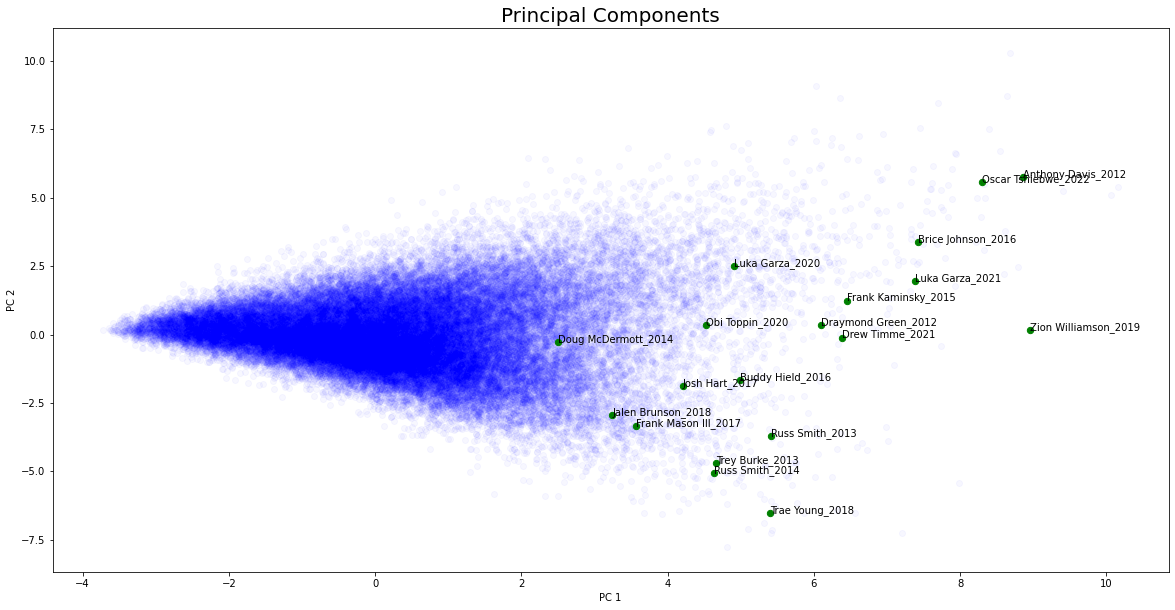

In [116]:


import matplotlib.pyplot as plt


fig, ax=plt.subplots(figsize=(20, 10))

plt.scatter(npoys.pc_1, npoys.pc_2, c='b', alpha = 0.03)
plt.scatter(poys.pc_1, poys.pc_2, c='g', s=40)

plt.title("Principal Components", fontsize=20)


for i in range(poys.shape[0]):
    plt.text(x=poys.pc_1[i],y=poys.pc_2[i],s=poys.player_name[i])

ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')

plt.show()



# test.loc[test['player_name'].str.contains('III_2017')]



In [117]:

test.sort_values(by='pc_1', ascending=False).head(60)


,player_id,eFG%_prnk,eFG%_norm_prnk,TS%_prnk,TS%_norm_prnk,pts_pm_prnk,pts_pm_norm_prnk,reb_pm_prnk,reb_pm_norm_prnk,ast_pm_prnk,...,to_pm_prnk,to_pm_norm_prnk,pf_pm_prnk,pf_pm_norm_prnk,season,player_name,player_team,pc_1,pc_2,is_poy
63,45882,0.000528,0.233417,0.000514,0.221544,0.001634,0.704293,0.002507,1.119270,0.000282,...,0.000369,0.160497,0.000430,0.187715,2010,DeMarcus Cousins_2010,DeMarcus Cousins,10.155256,5.393171,0
361,36578,0.000650,0.316862,0.000679,0.326267,0.001054,0.527152,0.003204,1.609839,0.000155,...,0.000180,0.092853,0.000299,0.144453,2009,DeJuan Blair_2009,DeJuan Blair,10.060358,5.111044,0
11481,31711,0.000786,0.365546,0.000764,0.348709,0.000473,0.218148,0.002636,1.286060,0.000439,...,0.000299,0.142191,0.000686,0.329864,2010,Brian Zoubek_2010,Brian Zoubek,9.403010,5.253114,0
6,4395628,0.000628,0.306399,0.000681,0.329192,0.001766,0.874069,0.001189,0.588427,0.000459,...,0.000186,0.090520,0.000104,0.051683,2019,Zion Williamson_2019,Zion Williamson,8.958906,0.162053,1
1486,56353,0.000708,0.318950,0.000723,0.316899,0.000916,0.399943,0.001291,0.589447,0.000174,...,0.000140,0.066858,0.000139,0.060477,2012,Anthony Davis_2012,Anthony Davis,8.860439,5.760151,1
218,44654,0.000701,0.315635,0.000708,0.307791,0.001310,0.572259,0.001617,0.738364,0.000606,...,0.000329,0.149565,0.000321,0.147773,2011,Markieff Morris_2011,Markieff Morris,8.785299,2.460918,0
4293,32037,0.000560,0.246563,0.000615,0.263768,0.000710,0.307194,0.001198,0.518519,0.000142,...,0.000259,0.113083,0.000241,0.102028,2009,Jarvis Varnado_2009,Jarvis Varnado,8.675468,10.296370,0
3591,32037,0.000646,0.256535,0.000673,0.259988,0.000806,0.323822,0.001008,0.411524,0.000126,...,0.000268,0.109197,0.000253,0.101112,2010,Jarvis Varnado_2010,Jarvis Varnado,8.637705,8.709280,0
123,31786,0.000517,0.239309,0.000537,0.242943,0.001434,0.626043,0.001454,0.661127,0.000210,...,0.000257,0.118499,0.000663,0.295821,2007,Darrell Arthur_2007,Darrell Arthur,8.615303,3.781574,0
2,36671,0.000504,0.224996,0.000573,0.252570,0.002048,0.989235,0.001660,0.809717,0.000179,...,0.000329,0.146382,0.000159,0.072306,2008,Michael Beasley_2008,Michael Beasley,8.592554,2.223027,0



### time series


In [321]:


pbox = load_player_boxscore_season(2022)


/var/folders/6j/0sqk1ykn5f10xfsflg6djktr0000gn/T/ipykernel_65801/2858446366.py:1: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  pbox = load_player_boxscore_season(2022)


In [520]:

## get team scores
team_scores = pbox.copy().groupby(['game_id','team_id'])['pts'].sum().reset_index()
team_scores['team_AorB'] = team_scores.groupby(['game_id'])['team_id'].rank('dense').astype(int).map({
    1:'A',
    2:'B'
})
team_scores = team_scores.pivot(index='game_id', columns=['team_AorB'], values=['team_id','pts']).reset_index()
team_scores.columns=['game_id','team_1','team_2','team_1_pts','team_2_pts']
game_dates = pbox.copy().drop_duplicates(subset=['game_id'])[['game_id','game_date']]
team_scores = team_scores.merge(game_dates, how='left')
team_scores = team_scores.sort_values(by='game_date').reset_index(drop=True)
pbox['team_id'] = pbox['team_id'].astype(int)
game_nums = pbox.copy().drop_duplicates(subset=['game_id','team_id'])['team_id'].value_counts()
# drop non D1 teams
valid_teams = game_nums.copy()[game_nums>=24]
valid_teams = valid_teams.reset_index()
valid_teams.columns=['team_id','game_count']
valid_teams['matrix_index'] = (valid_teams['team_id'].rank()-1).astype(int)
team_id2index=valid_teams.copy().set_index('team_id').to_dict()['matrix_index']
team_scores = team_scores.loc[(team_scores['team_1'].isin(valid_teams.team_id))&(team_scores['team_2'].isin(valid_teams.team_id))].reset_index(drop=True)
valid_teams = list(valid_teams.team_id.values)


In [566]:
team_scores['winning_team'] = np.where(team_scores['team_1_pts']>team_scores['team_2_pts'], team_scores['team_1'].copy(), team_scores['team_2'].copy())
team_scores['losing_team'] = np.where(team_scores['team_2_pts']>team_scores['team_1_pts'], team_scores['team_1'].copy(), team_scores['team_2'].copy())
team_scores['margin'] = (team_scores['team_1_pts'].copy()-team_scores['team_2_pts'].copy()).abs()
team_scores['margin'] = np.log(team_scores['margin']+1)
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
team_scores['margin'] = mms.fit_transform(team_scores['margin'].values.reshape(-1,1))
team_scores['margin'] += 1 # reward for winning


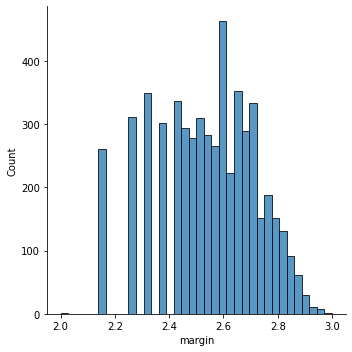

In [567]:
import seaborn as sns
sns.displot(team_scores['margin']+1)

In [650]:
def load_kenpom(season):
    kp = pd.read_csv(os.path.join(DATA_PATH, f'kenpom/{season}.csv'))
    return kp.rename(columns={'TeamName':'kenpom_name'})
k22 = load_kenpom(2022)

team_index2id = {v:k for k,v in team_id2index.items()}
teams_id2name = pbox.copy().drop_duplicates(subset=['team_id'])[['team_id','team_short_display_name']].set_index('team_id').to_dict()['team_short_display_name']
teams_name2id = {v:k for k,v in teams_id2name.items()}
tname2kenpom = load_dict(os.path.join(DATA_PATH, 'IDs/tname2kenpom'))

def calc_ratings(tm_matrix):
    
    d = 0.2
    N = tm_matrix.shape[1]
    A = (d * tm_matrix + (1 - d) / N)
    v = np.repeat(1/num_teams, num_teams)
    for i in range(100):
        v = A@v
        norm = np.linalg.norm(v)
        v = v/norm
        
    team_ratings = pd.DataFrame(team_index2id.values(), index=team_index2id.keys()).reset_index()
    team_ratings.columns=['team_index','team_id']
    team_ratings = team_ratings.sort_values(by='team_index')
    team_ratings['rating'] = v
    team_ratings['team_name'] = team_ratings['team_id'].map(teams_id2name)
    
    return team_ratings

def calc_corr(team_ratings):
    team_ratings['kenpom_name'] = team_ratings['team_name'].map(tname2kenpom)
    # ## merge kenpom
    team_ratings = team_ratings.merge(k22[['kenpom_name','AdjEM']].copy(), how='left', on='kenpom_name')
    return team_ratings[['rating','AdjEM']].corr('spearman').values[0][1]


1

In [710]:
import math as m
from scipy.stats import entropy

teams = valid_teams
num_teams = len(teams)
# initialize time matrix
team_matrix = np.ones((num_teams, num_teams))*0.001 # dampening factor

dates = list(team_scores['game_date'].unique())
entropies = []
corrs = []
prev_date = '2021-11-09'
for date in tqdm(dates[1:]):
    decay = (pd.Timestamp(date)-pd.Timestamp(prev_date)).days
    day_games = team_scores.copy().loc[team_scores['game_date']==date].reset_index(drop=True)
    coords = [tuple((team_id2index[winner],team_id2index[loser])) for winner, loser in day_games[['winning_team','losing_team']].values]
    margins = list(day_games['margin'].values)
    update_matrix = np.zeros((num_teams, num_teams))
    for index, coord in enumerate(coords):
        update_matrix[coord[0], coord[1]] = margins[index]
    team_matrix *= np.exp(-(1/1500)*decay)
    team_matrix += update_matrix
    entr = entropy(team_matrix)
    entropies.append(np.mean(entr))
    tm_rtgs = calc_ratings(team_matrix)
    kenpom_corr = calc_corr(tm_rtgs)
    corrs.append(kenpom_corr)
    prev_date = date

    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:01<00:00, 84.72it/s]


In [711]:
import altair as alt
from datetime import datetime
from matplotlib import animation

plt.style.use('ggplot')
entropy_log = pd.DataFrame(zip(dates, entropies),columns=['date','entropy'])
corr_log = pd.DataFrame(zip(dates, corrs),columns=['date','kenpom_correlation'])
to_graph = pd.merge(entropy_log, corr_log, how='left', on='date')
to_graph
# alt.Chart(entropy_log).mark_line().encode(
#     x='date',
#     y=alt.Y('entropy', scale=alt.Scale(domain=(3, 7)))
# )


# # save the plot as a file
# fig.savefig('entropy_kenpom.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')



,date,entropy,kenpom_correlation
0,2021-11-09,4.536516,0.505295
1,2021-11-10,4.330608,0.587845
2,2021-11-11,4.189414,0.572015
3,2021-11-12,3.456292,0.618428
4,2021-11-13,3.177537,0.638280
...,...,...,...
138,2022-03-30,2.534873,0.941622
139,2022-03-31,2.535074,0.941847
140,2022-04-01,2.535415,0.941888
141,2022-04-02,2.535129,0.941896


MovieWriter ffmpeg unavailable; using Pillow instead.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


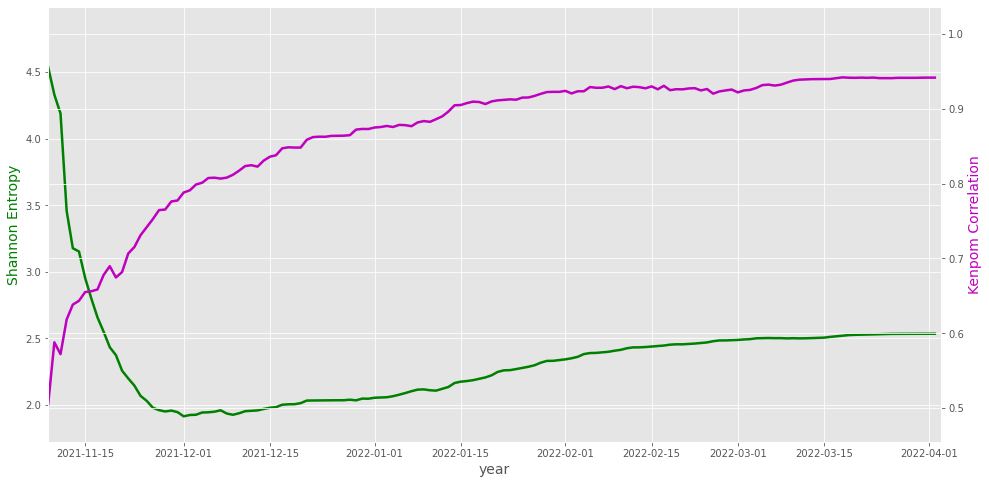

In [712]:

from IPython import display
if anim:
    del anim
fig,ax = plt.subplots(figsize=(16, 8))
plt.title("Entropy vs. End of Year\nKenpom Correlation", fontsize=18)
x = [datetime.strptime(dstr,'%Y-%m-%d') for dstr in to_graph.date]
ax.plot(x, to_graph.entropy, color="g")
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("Shannon Entropy",color="g",fontsize=14)
ax2=ax.twinx()
ax2.plot(x, to_graph.kenpom_correlation,color="m")
ax2.set_ylabel("Kenpom Correlation",color="m",fontsize=14)
# plt.show()
x0 = x[0]
tfinal = x[-1]
def animate(i):
    #https://stackoverflow.com/questions/62335385/animating-a-line-plot-over-time-in-python
    ax.cla() # clear the previous image
    ax2.cla() # clear the previous image
    ax.plot(x[:i], to_graph.entropy[:i],color="g",linewidth=2.5)
    ax.set_xlabel("year",fontsize=14)
    ax.set_ylabel("Shannon Entropy",color="g",fontsize=14)
    ax2.plot(x[:i], to_graph.kenpom_correlation[:i],color="m",linewidth=2.5)
    ax2.set_ylabel("Kenpom Correlation",color="m",fontsize=14)
    ax.set_xlim([x0, tfinal]) # fix the x axis
    ax2.set_xlim([x0, tfinal]) 
    ax.set_ylim([0.9*np.min(to_graph.entropy), 1.1*np.max(to_graph.entropy)])
    ax2.set_ylim([0.9*np.min(to_graph.kenpom_correlation), 1.1*np.max(to_graph.kenpom_correlation)])

anim = animation.FuncAnimation(fig, animate, frames = len(x), interval=3, blit = False)
anim.save('./kenpom_entropy.gif')



In [713]:
days_past = 10
np.exp(-(1/300)*days_past)


0.9672161004820059

In [685]:
!pip3 install ffmpeg


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=9b5371b4f391943ca3a1e35dfb0e63bf7a721ee06f12e6e9d6e0fa5baadfba44
  Stored in directory: /Users/blakeatkinson/Library/Caches/pip/wheels/30/33/46/5ab7eca55b9490dddbf3441c68a29535996270ef1ce8b9b6d7
Successfully built ffmpeg
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Pyt

In [595]:

team_ratings.head()

,team_index,team_id,rating,team_name
57,0,2,0.063076,Auburn
33,1,5,0.060296,UAB
101,2,6,0.053956,South Alabama
11,3,8,0.062606,Arkansas
210,4,9,0.051829,Arizona State


In [596]:



k22.head()

,Season,kenpom_name,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM
0,2022,Abilene Christian,71.1340,47,70.3257,37,102.4850,166,104.0550,157,96.9711,59,100.6790,128,3.37570,131
1,2022,Air Force,63.4280,347,63.2371,342,92.9406,334,95.5363,306,104.3160,246,104.0210,208,-8.48428,269
2,2022,Akron,63.6546,343,62.0843,352,107.3680,55,105.6420,121,99.9099,124,102.0200,158,3.62246,126
3,2022,Alabama,73.2690,10,71.9053,11,108.5320,44,115.1820,16,104.2540,241,98.6141,92,16.56770,28
4,2022,Alabama A&M,68.3935,162,66.5795,212,88.6957,354,87.3290,355,96.2221,45,100.8300,130,-13.50110,314


In [597]:
tname2kenpom['Iowa']

'Iowa'

In [605]:



# pace_series[['pace_rank','RankTempo','RankAdjTempo']].corr('spearman')


0.8942686916806004

In [584]:
team_ratings['team_name'] = team_ratings['team_id'].map(teams_id2name)
team_ratings.sort_values(by='rating',ascending=False).head(20)

,team_index,team_id,rating,team_name,kenpom_name,RankAdjTempo_x,RankAdjTempo_y
227,227,2305,0.068067,Kansas Jayhawks,NaN,NaN,NaN
5,5,12,0.067295,Arizona Wildcats,NaN,NaN,NaN
115,115,248,0.066798,Houston Cougars,NaN,NaN,NaN
70,70,150,0.066368,Duke Blue Devils,NaN,NaN,NaN
102,102,222,0.064473,Villanova Wildcats,NaN,NaN,NaN
218,218,2250,0.064462,Gonzaga Bulldogs,NaN,NaN,NaN
73,73,153,0.064040,North Carolina Tar Heels,NaN,NaN,NaN
282,282,2509,0.063714,Purdue Boilermakers,NaN,NaN,NaN
317,317,2633,0.063089,Tennessee Volunteers,NaN,NaN,NaN
0,0,2,0.063076,Auburn Tigers,NaN,NaN,NaN


In [461]:

team_ratings = pd.DataFrame(zip())



array([0.04737988, 0.04804081, 0.04968134, 0.04898757, 0.05312721,
       0.04715838, 0.05498786, 0.05455725, 0.04845216, 0.05877822,
       0.0533058 , 0.05539255, 0.04839691, 0.05066781, 0.05327992,
       0.048628  , 0.0484536 , 0.05106914, 0.04864536, 0.05549293,
       0.05131674, 0.05742981, 0.05473802, 0.05797356, 0.05035904,
       0.0509004 , 0.05441649, 0.05282386, 0.05030725, 0.05443235,
       0.05162717, 0.05744762, 0.05491907, 0.05890034, 0.05019522,
       0.05190658, 0.04834181, 0.05638524, 0.051564  , 0.05247176,
       0.05111871, 0.05250566, 0.05131659, 0.06135032, 0.05002577,
       0.05263499, 0.04664977, 0.05059966, 0.04837147, 0.05497296,
       0.05075209, 0.05004515, 0.05496525, 0.05119096, 0.05780627,
       0.05059939, 0.05620268, 0.05401836, 0.05345483, 0.0491949 ,
       0.05267656, 0.05119778, 0.05274006, 0.0538401 , 0.0503543 ,
       0.05129092, 0.05627052, 0.05452624, 0.0485612 , 0.05215242,
       0.04754244, 0.05237628, 0.0552699 , 0.05064898, 0.04987

In [118]:

### experiment
# A = np.array([
#     [0, 0.5, 0.5, 0.33],
#     [0, 0, 0.5, 0.33],
#     [0, 0, 0, 0.33],
#     [0, 0, 0, 0]
# ])

A = np.array([
    [0, 1, 1, 1],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

d = 0.9
N = A.shape[1]
A = (d * A + (1 - d) / N)
v = [0.25, 0.25, 0.25, 0.25]


for i in range(5):
    v = A@v
    norm = np.linalg.norm(v)
    v = v/norm
    
print(np.mean(v))
v = [0.25, 0.25, 0.25, 0.25]
for i in range(10):
    v = A@v
    norm = np.linalg.norm(v)
    v = v/norm
print(np.mean(v))

for i in range(100):
    v = A@v
    norm = np.linalg.norm(v)
    v = v/norm
print(np.mean(v))


v


0.3704679855252018
0.3743866459974583
0.3741268865854114


array([0.91444619, 0.37077268, 0.15033403, 0.06095465])

In [81]:

a = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

b = np.array([
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])

c = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

T = 0.8 * a + 0.9 * b + 1* c

d = 0.9
N = T.shape[1]
T = (d * T + (1 - d) / N)
v = [0.25, 0.25, 0.25, 0.25]


for i in range(5):
    v = T@v
    norm = np.linalg.norm(v)
    v = v/norm
    
print(np.mean(v))
v
v = [0.25, 0.25, 0.25, 0.25]
for i in range(10):
    v = T@v
    norm = np.linalg.norm(v)
    v = v/norm
print(np.mean(v))
v

for i in range(100):
    v = T@v
    norm = np.linalg.norm(v)
    v = v/norm
print(np.mean(v))
v


0.3762808763932521
0.379381373021151
0.3792032070040248


array([0.90522048, 0.3895661 , 0.1566547 , 0.06537155])